In [12]:
from phidl import Device, Layer, LayerSet, set_quickplot_options
from phidl import quickplot as qp # Rename "quickplot()" to the easier "qp()"
import phidl.geometry as pg
import numpy as np

#Name of all layers

ls = LayerSet() # Create a blank LayerSet

ls.add_layer(name = 'si', gds_layer = 0, gds_datatype = 0,
             description = 'Si FETs', color = 'gray')

ls.add_layer(name = 'metal', gds_layer = 1, gds_datatype = 0,
             description = 'Metal contacts and interconnects', color = "gold")

ls.add_layer(name = 'open_areas', gds_layer = 2, gds_datatype = 0, description = 'Opening to metal pads and wires', color = 'lightblue')

ls.add_layer(name = 'isolation', gds_layer = 3, gds_datatype = 0, description="Isolating between Si and interconnects", color = "lightgreen")



In [13]:
### Dimensions
channel_width = 0.050
channel_length = 5

nanowires = 20
C_width = 10
C_height= 10

pad_size = 500
line_width = 5

col = 2   #Must change a lot if we change this one , now its just an extra foor loop
row = 3
dist = 300

mid_gap = 150
MC_ratio = 0.75
SiO2_ratio = 0.65   #Bit smaller than MC_ratio to make sure it is covered
border = 5    #was 2 before

In [14]:
C = Device("channel")


channel = pg.rectangle((channel_length, channel_width), layer= ls["si"])
C.add(channel)

Device (name "channel" (uid 62), ports [], aliases [], 1 polygons, 0 references)

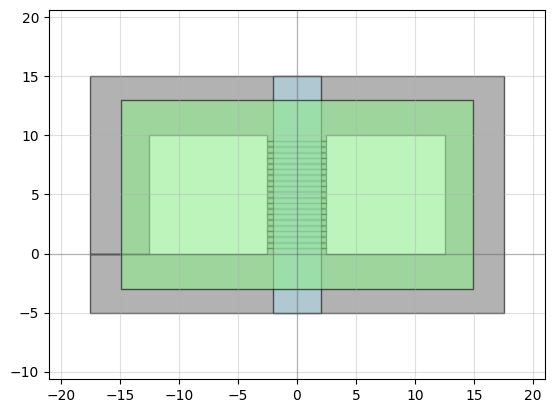

In [15]:
FET = Device('transistor')
K = Device('channel_opening')

separation = C_height/(nanowires+1)



for lines in range(nanowires):
    channel_ref = FET << C
    channel_ref.move((-channel_length/2,(lines+1)*separation-channel_width/2))


S = pg.rectangle((C_width,C_height), layer= ls["si"])
FET.add(S)
S.move((-C_width-channel_length/2,0))

D = pg.rectangle((C_width,C_height), layer= ls["si"])
FET.add(D)
D.move((channel_length/2,0))

O = pg.outline(FET, distance = border, precision = 1e-6, layer = 0)

G= pg.rectangle((O.xsize*0.85,O.ysize*0.8), layer= ls["isolation"])

G_ref = O << G
G_ref.center = FET.center
# G = pg.rectangle((C_width*SiO2_ratio,C_height*SiO2_ratio), layer= ls["isolation"])
# GL_ref = O << G
# GL_ref.center= FET.center
# GL_ref.movex(-C_width/2-channel_length/2)

# GR_ref = O << G
# GR_ref.center= FET.center
# GR_ref.movex(+C_width/2+channel_length/2)




K.add(pg.rectangle((channel_length*0.8,C_height*2), layer= ls["open_areas"]))   #Now the channels just meet, but should not be a problem
K_ref = O << K
K_ref.center = FET.center
#K_ref.movey(-C_height/2)
#print(FET.center)



#qp(FET)



qp(O) # quickplot it!

In [16]:
M = Device("pads_bottom")

square = pg.rectangle(size= (pad_size,pad_size), layer = ls["metal"])
M.add(square)

#qp(M)


Device (name "pads_bottom" (uid 74), ports [], aliases [], 1 polygons, 0 references)

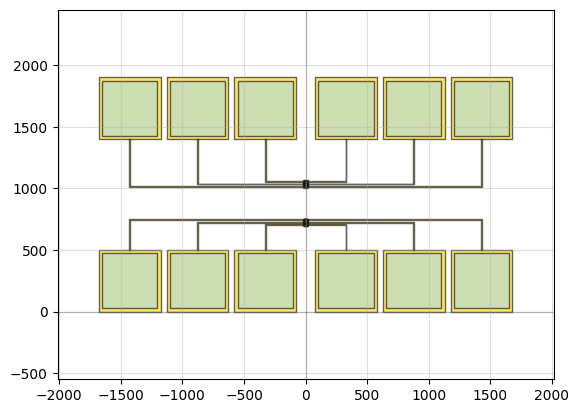

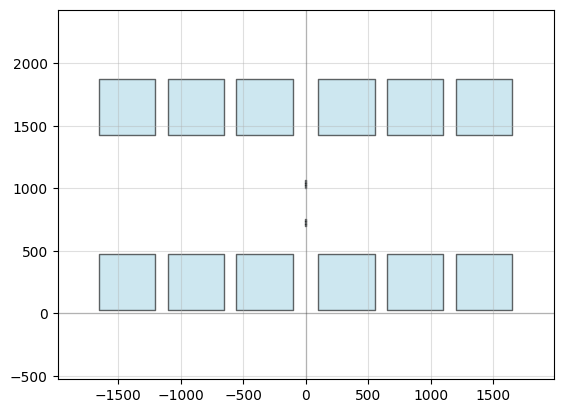

In [17]:
import phidl.routing as pr
Q = Device("MyDevice")



MC = pg.rectangle(size=(C_width*MC_ratio,C_height*MC_ratio), layer= ls["metal"])

#Opening to metal pads
scl = 0.9
MP = Device("metalPads")
metal_pad = pg.rectangle(size=(M.xsize*scl, M.ysize*scl), layer= 2) 
MP.add(metal_pad)


#TiSi = pg.rectangle((C_width*0.8,C_height*0.8), layer= ls["metal"])
y_centers = np.arange(row)*C_height*2    #Adjust this to adjust space between rows of FETs

F = Device("MultipleFETS")

for yidx, y0 in enumerate(y_centers):
    shift = y0+1*pad_size + 200  # +2 to move the array a bit up
    # FET_ref_test = Q << FET
    # FET_ref_test.movey(shift)

    FET_ref_test = Q << O
    FET_ref_test.movey(shift)

    name1 = '{}'.format(yidx)
    source_port = Q.add_port(name=name1+'1', midpoint=(-C_width*0.7-channel_length/2, shift+C_height/2), width= line_width, orientation=180)  #Some of the interconnect lays over the Si FET pads. Might result in a double layer
    drain_port = Q.add_port(name=name1+'2', midpoint=(C_width*0.7+channel_length/2, shift+C_height/2), width= line_width,  orientation=0)
      

    pad_shift_R = (yidx*pad_size*1.1) + (channel_length/2 + mid_gap/2)
    name_right = "{}".format(yidx)
    pad_ref_right = Q << M
    pad_ref_right.movex(pad_shift_R)
    metpad_ref_right = Q << MP
    metpad_ref_right.center = pad_ref_right.center
    contact_right = Q.add_port(midpoint=(pad_size/2+pad_shift_R,pad_size), width=line_width, name= name1+name_right+"R", orientation=90)
    Q.add_ref(pr.route_sharp(drain_port, contact_right, route_type='manhattan', layer = ls["metal"]))
    MC_ref_right = Q << MC                                                                                                          #Metal contacts
    MC_ref_right.move((FET_ref_test.x+channel_length/2+C_width*(1-MC_ratio)/2, FET_ref_test.y-C_height*MC_ratio/2))
    


    pad_shift_L = -pad_shift_R-pad_size
    name_left ="{}".format(yidx)
    pad_ref_left = Q << M
    pad_ref_left.movex(pad_shift_L)
    metpad_ref_left = Q << MP
    metpad_ref_left.center = pad_ref_left.center
    contact_left = Q.add_port(midpoint=(pad_size/2+pad_shift_L,pad_size), width=line_width, name= name1+name_left+"L", orientation=90)
    Q.add_ref(pr.route_sharp(source_port, contact_left, route_type='manhattan', layer = ls["metal"]))
    MC_ref_left = Q << MC                                                                                                               #Metal contacts
    MC_ref_left.move((FET_ref_test.x-channel_length/2-C_width + C_width*(1-MC_ratio)/2, FET_ref_test.y-C_height*MC_ratio/2))               #Might be a separate layer





for yidx0, y00 in enumerate(y_centers):
    shift = -y00+1*pad_size + 550  # 100 is the distance between the top of the FET and the bottom of the pads, 1.5 is ish the distance between the FET cols
    #FET_ref_test = Q << FET
    #FET_ref_test.movey(shift)

    FET_ref_test = Q << O
    FET_ref_test.movey(shift)

    name1 = '{}'.format(yidx0)
    source_port = Q.add_port(name=name1+'1'+'col2', midpoint=(-C_width*0.7-channel_length/2, shift+C_height/2), width= line_width, orientation=180)  #Some of the interconnect lays over the Si FET pads. Might result in a double layer
    drain_port = Q.add_port(name=name1+'2'+'col2', midpoint=(C_width*0.7+channel_length/2, shift+C_height/2), width= line_width,  orientation=0)
      

    pad_shift_R = (yidx0*pad_size*1.1) + (channel_length/2 + mid_gap/2)
    name_right = "{}".format(yidx0)
    pad_ref_right = Q << M
    pad_ref_right.movex(pad_shift_R)
    pad_ref_right.movey(2.4*pad_size+200)  #Kinda arbitary value to make almost equal spacing between FETs and pad rows
    metpad_ref_right = Q << MP
    metpad_ref_right.center = pad_ref_right.center
    contact_right = Q.add_port(midpoint=(pad_size/2+pad_shift_R, 2.4*pad_size + 200), width=line_width, name= name1+name_right+"R"+"col2", orientation=270)
    Q.add_ref(pr.route_sharp(drain_port, contact_right, route_type='manhattan', layer = ls["metal"]))
    MC_ref_right = Q << MC                                                                                                          #Metal contacts
    MC_ref_right.move((FET_ref_test.x+channel_length/2+C_width*(1-MC_ratio)/2, FET_ref_test.y-C_height*MC_ratio/2))
    


    pad_shift_L = -pad_shift_R-pad_size
    name_left ="{}".format(yidx0)
    pad_ref_left = Q << M
    pad_ref_left.movex(pad_shift_L)
    pad_ref_left.movey(2.4*pad_size + 200)
    metpad_ref_left = Q << MP
    metpad_ref_left.center = pad_ref_left.center
    contact_left = Q.add_port(midpoint=(pad_size/2+pad_shift_L, 2.4*pad_size + 200), width=line_width, name= name1+name_left+"L"+"col2", orientation=270)
    Q.add_ref(pr.route_sharp(source_port, contact_left, route_type='manhattan', layer = ls["metal"]))
    MC_ref_left = Q << MC                                                                                                               #Metal contacts
    MC_ref_left.move((FET_ref_test.x-channel_length/2-C_width + C_width*(1-MC_ratio)/2, FET_ref_test.y-C_height*MC_ratio/2))               #Might be a separate layer



set_quickplot_options(show_ports=False, show_subports = False)









qp(Q)

qp(pg.extract(Q, layers = [2]))

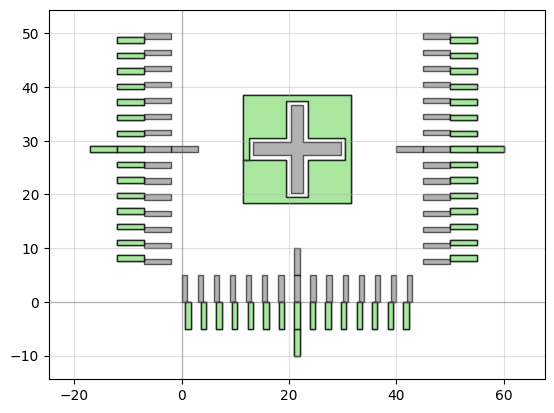

In [18]:
AM = Device("alignment_mark")


scale = 1
spacing = 2*scale
notches = 7

set_layers = {1,2,3}
A = pg.litho_calipers(
notch_size = [1*scale, 5*scale],
notch_spacing = spacing,
num_notches = notches,
offset_per_notch = 0.1*scale,
row_spacing = 0,
layer1 = ls["si"],
#layer2 = ls["metal"]),
layer2 = set_layers)

A_ref1 = AM << A

A_ref2 = AM << A
A_ref2.rotate(90)
A_ref2.move([50*scale, 7*scale])

A_ref3 = AM << A
A_ref3.rotate(270)
A_ref3.move([-7*scale, 50*scale])

size = 20*scale

cross = pg.cross(length= size*0.9, width=size*0.2, layer = ls["si"])
sq_invert = pg.invert(cross, border= 1*scale, layer= ls["metal"])
sq_invert_ref = AM << sq_invert
sq_invert_ref.move(A_ref1.center+[0,A_ref2.center[1]])

sq_invert_MP = pg.invert(cross, border= 1*scale, layer= ls["open_areas"])
sq_invert_MP_ref = AM << sq_invert_MP
sq_invert_MP_ref.move(A_ref1.center+[0,A_ref2.center[1]])

sq_invert_SiO2 = pg.invert(cross, border= 1*scale, layer= ls["isolation"])
sq_invert_SiO2_ref = AM << sq_invert_SiO2
sq_invert_SiO2_ref.move(A_ref1.center+[0,A_ref2.center[1]])

cross_shrink = pg.offset(cross, distance= -0.8*scale, layer= ls["si"])
cross_shrink_ref = AM << cross_shrink
cross_shrink_ref.move(A_ref1.center+[0,A_ref2.center[1]])




qp(AM) # quickplot the geometry

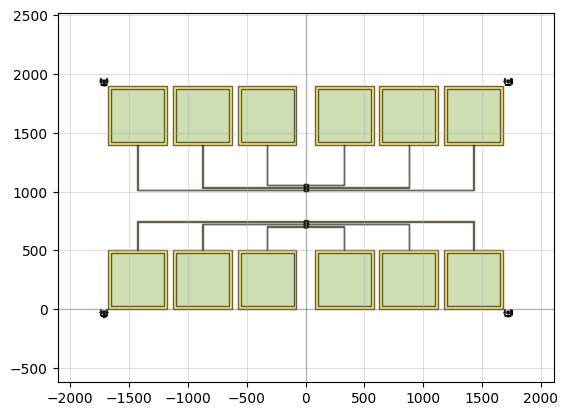

In [19]:
#Adding alingmentmarks
#am_array_ref = Q.add_array(AM, columns= 2, rows= 2, spacing= [100, 100])
from phidl import Group
import phidl.device_layout as pdl
S = pdl.Device("All")
S.add(Q)

c1 = S << AM
c2 = S << AM
c3 = S << AM
c4 = S << AM


top = Group([c1, c2])


bottom = Group([c3, c4])



c1.xmax = Q.xmin -1*1.5
c1.ymin = Q.ymax +1*1.5

c2.xmin = Q.xmax +1*1.5
c2.ymin = Q.ymax +1*1.5

c3.xmin = Q.xmax +1*1.5
c3.ymax = Q.ymin -1*1.5

c4.xmax = Q.xmin -1*1.5
c4.ymax = Q.ymin -1*1.5

#all_box = S.bbox
#S << pg.bbox(all_box, layer=1)

D = pg.basic_die(
              size = (10000, 5000), # Size of die
              street_width = 100,   # Width of corner marks for die-sawing
              street_length = 1000, # Length of corner marks for die-sawing
              die_name = 'chip01',  # Label text
              text_size = 500,      # Label text size
              text_location = 'SW', # Label text compass location e.g. 'S', 'SE', 'SW'
              layer = 1,
              draw_bbox = False,
              bbox_layer = 99,
              )
#S<<D
qp(S)

In [20]:
### Adding text

RS = pg.text(text = 'reStatus', size = 400,
            justify = 'center', layer = 1)

reStatus = S<<RS
reStatus.move([0, 2000])

NA = pg.text(text = 'Design by Nicolai Austad', size = 200,
            justify = 'center', layer = 1)

nicolaiaustad = S<<NA
nicolaiaustad.move([0, -400])





DeviceReference (parent Device "text", ports [], origin [   0 -400], rotation 0, x_reflection False)

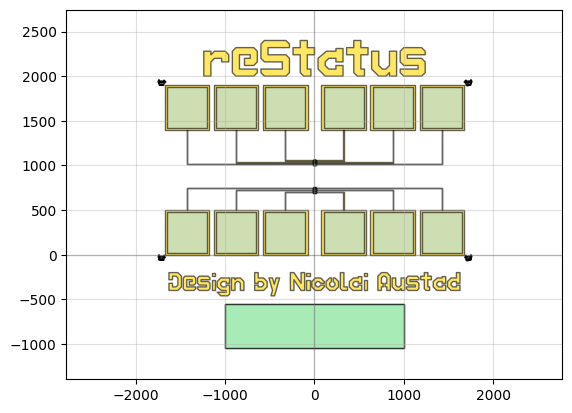

In [21]:
## Opening back gate
backgate = pg.rectangle(size = (2000, 500), layer = 2)
backgate_ref = S << backgate
backgate_ref.center = (0,-800)

backgate_SiO2= pg.rectangle(size=(backgate.xsize, backgate.ysize), layer= 3) 
backgate_ref_SiO2 = S << backgate_SiO2

backgate_ref_SiO2.center = (0,-800)

qp(S)

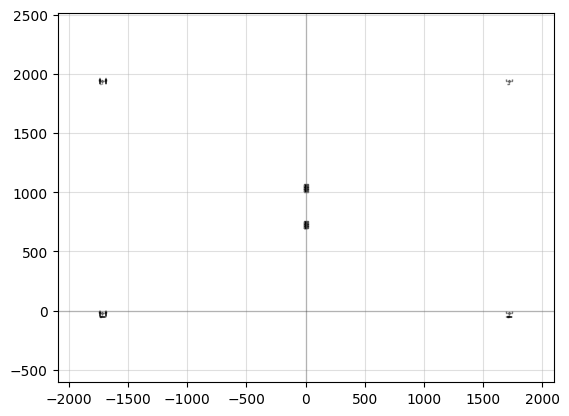

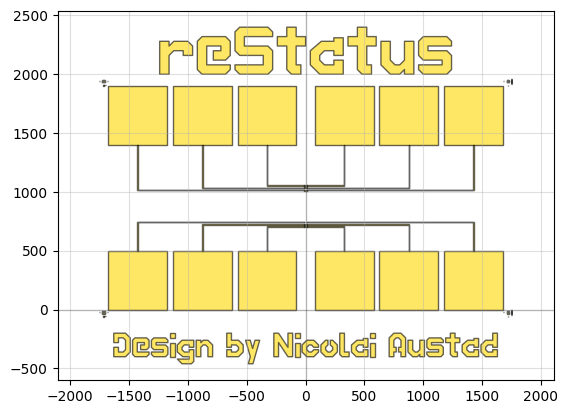

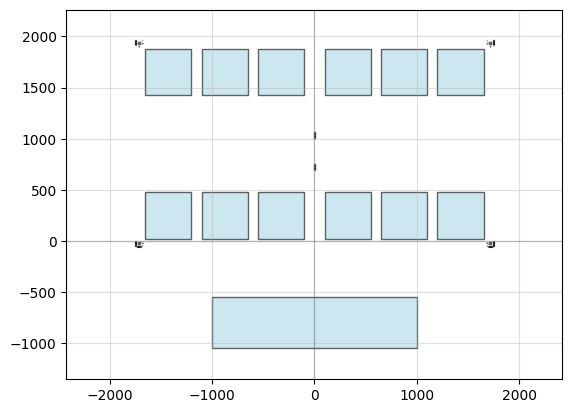

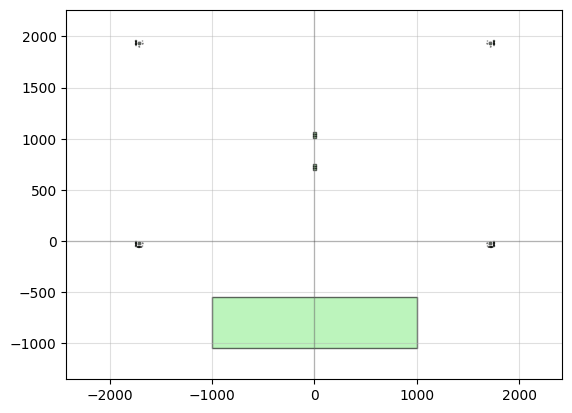

In [22]:
Si_EX = pg.extract(S, layers=[0])
qp(Si_EX)

#Si_EX.write_gds("NFA_2000_EBL_Si_5um", unit=1e-06, precision=1e-09, auto_rename=True, max_cellname_length=28, cellname='toplevel')

Metal_EX = pg.extract(S, layers=[1])
qp(Metal_EX)

#Metal_EX.write_gds("NFA_FET_Metal_5um", unit=1e-06, precision=1e-09, auto_rename=True, max_cellname_length=28, cellname='toplevel')

Pads_EX = pg.extract(S, layers=[2])
qp(Pads_EX)

#Pads_EX.write_gds("NFA_Pads_5um", unit=1e-06, precision=1e-09, auto_rename=True, max_cellname_length=28, cellname='toplevel')

Iso_EX = pg.extract(S, layers=[3])
qp(Iso_EX)

#Iso_EX.write_gds("NFA_Iso_5um", unit=1e-06, precision=1e-09, auto_rename=True, max_cellname_length=28, cellname='toplevel')

